Initial Setup: Imported essential libraries for data loading, processing, and model building.
This includes PyTorch for deep learning, Pandas for tabular data handling, Albumentations for image augmentation, and utilities like zipfile and glob to access data files.

In [4]:
# Importing NumPy – this library helps us handle numerical operations efficiently 
import numpy as np
# Bringing in PyTorch – a powerful deep learning framework
import torch
# nn stands for Neural Network – this module gives us all the building blocks to build and train neural nets
import torch.nn as n
# To work with zip files 
import zipfile
# Pandas – great for working with structured data like tables, CSV files, and DataFrames
import pandas as pd
# Glob lets us find files or folders using patterns (like all CSVs in a folder)
import glob
# Albumentations is a popular library for image transformations (like resizing, cropping, etc.)
import albumentations as A
# ToTensorV2 is used to convert images into PyTorch tensors, which the model can understand
from albumentations.pytorch import ToTensorV2

Loading training and testing metadata directly from a ZIP file

Combined both datasets into a single DataFrame for easier processing

Displayed the first few records to understand data structure



In [5]:
with zipfile.ZipFile("/home/webadmin/Downloads/isic-2024-challenge.zip") as z:
    with z.open("train-metadata.csv") as f:
        train_df = pd.read_csv(f)
    with z.open("test-metadata.csv") as f:
        test_df = pd.read_csv(f)

all_df = pd.concat([train_df, test_df]).reset_index(drop=True) 
display(train_df.head())
display(test_df.head())

/tmp/ipykernel_8969/401907491.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [6]:
df = train_df.copy()
print(f"Number of images: {df.shape[0]}, number of positive cases: {df.target.sum()}, number of negative cases: {(df['target'] == 0).sum()}, number of patients: {df['patient_id'].nunique()}")
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

Number of images: 401059, number of positive cases: 393, number of negative cases: 400666, number of patients: 1042


Note that number of images is less than number of patients, which means one patient could have multiple pictures.

ADA

In [7]:
print(df.columns)

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

To see five patients' information

In [8]:
 df.T.sample(n=5, axis=1)

,116618,14799,342414,362621,374589
isic_id,ISIC_2965084,ISIC_0436395,ISIC_8554524,ISIC_9051522,ISIC_9342971
target,0,0,0,0,0
patient_id,IP_8810058,IP_7770500,IP_5580991,IP_5714646,IP_7587482
age_approx,65.0,55.0,60.0,40.0,65.0
sex,NaN,male,male,male,male
anatom_site_general,upper extremity,upper extremity,anterior torso,upper extremity,head/neck
clin_size_long_diam_mm,5.78,3.37,6.49,3.41,3.0
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: XP,3D: white,3D: XP,3D: XP,3D: XP
tbp_lv_A,20.15335,22.91332,17.88187,13.98247,22.14187


Checking NaN values

In [9]:
df.isna().sum()

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

we can see that majority of idd_2, iddx_3,iddx_4,iddx_4, iddx_5, mel_motiotic_index,mel_thick_mm are none, therefore we can drop these columns
as well as some other columns 


In [10]:
def drop_columns(df):
    columns = ['isic_id', 'copyright_license', 'attribution', 'image_type', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4',
               'iddx_5', 'iddx_full', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type', 'tbp_lv_dnn_lesion_confidence',
               'lesion_id']

    for column in columns:
        try:
            df.drop(column, axis=1, inplace=True)
            print(f"Dropped column: {column}")
        except KeyError as e:
            print('No column with name', e)

    return df


In [11]:
df_new=drop_columns(df)

Dropped column: isic_id
Dropped column: copyright_license
Dropped column: attribution
Dropped column: image_type
Dropped column: iddx_1
Dropped column: iddx_2
Dropped column: iddx_3
Dropped column: iddx_4
Dropped column: iddx_5
Dropped column: iddx_full
Dropped column: mel_mitotic_index
Dropped column: mel_thick_mm
Dropped column: tbp_tile_type
Dropped column: tbp_lv_dnn_lesion_confidence
Dropped column: lesion_id


Filling Na with modes 

In [12]:
df_new.isna().sum()
#we can repalce NA values with mode
modes=df.mode().iloc[0]
df_new.fillna(modes, inplace=True)

Next, we would like to seperate all the variables as continuous variables and categorical variables

In [13]:
cat_df=['patient_id','target','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
con_df=[x for x in df_new.columns if x not in cat_df]
for col in cat_df:
  df_new[col]=df_new[col].astype('category').cat.codes


Next we proceed with the random forest 

In [14]:
from numpy import random
from sklearn.model_selection import train_test_split
X = df_new.drop(columns=['target'])
y = df_new['target']
X_train, X_test,y_train, y_test = train_test_split (X,y,test_size=0.25,shuffle=True, stratify=df_new['target'])

I chose Random Forest because it's a reliable and easy-to-use machine learning model. It combines several decision trees to make accurate predictions and reduces the chances of overfitting. It works well even with complex data and doesn’t need a lot of tuning or feature scaling. This makes it a good starting point for comparing with other models like deep learning or Markov Chains.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

rf = RandomForestClassifier(100, min_samples_leaf=5)
print(X_train.shape)
print(y_train.shape)
rf.fit(X_train,y_train)

(300794, 39)
(300794,)


RandomForestClassifier(min_samples_leaf=5)

And use it to the features importance

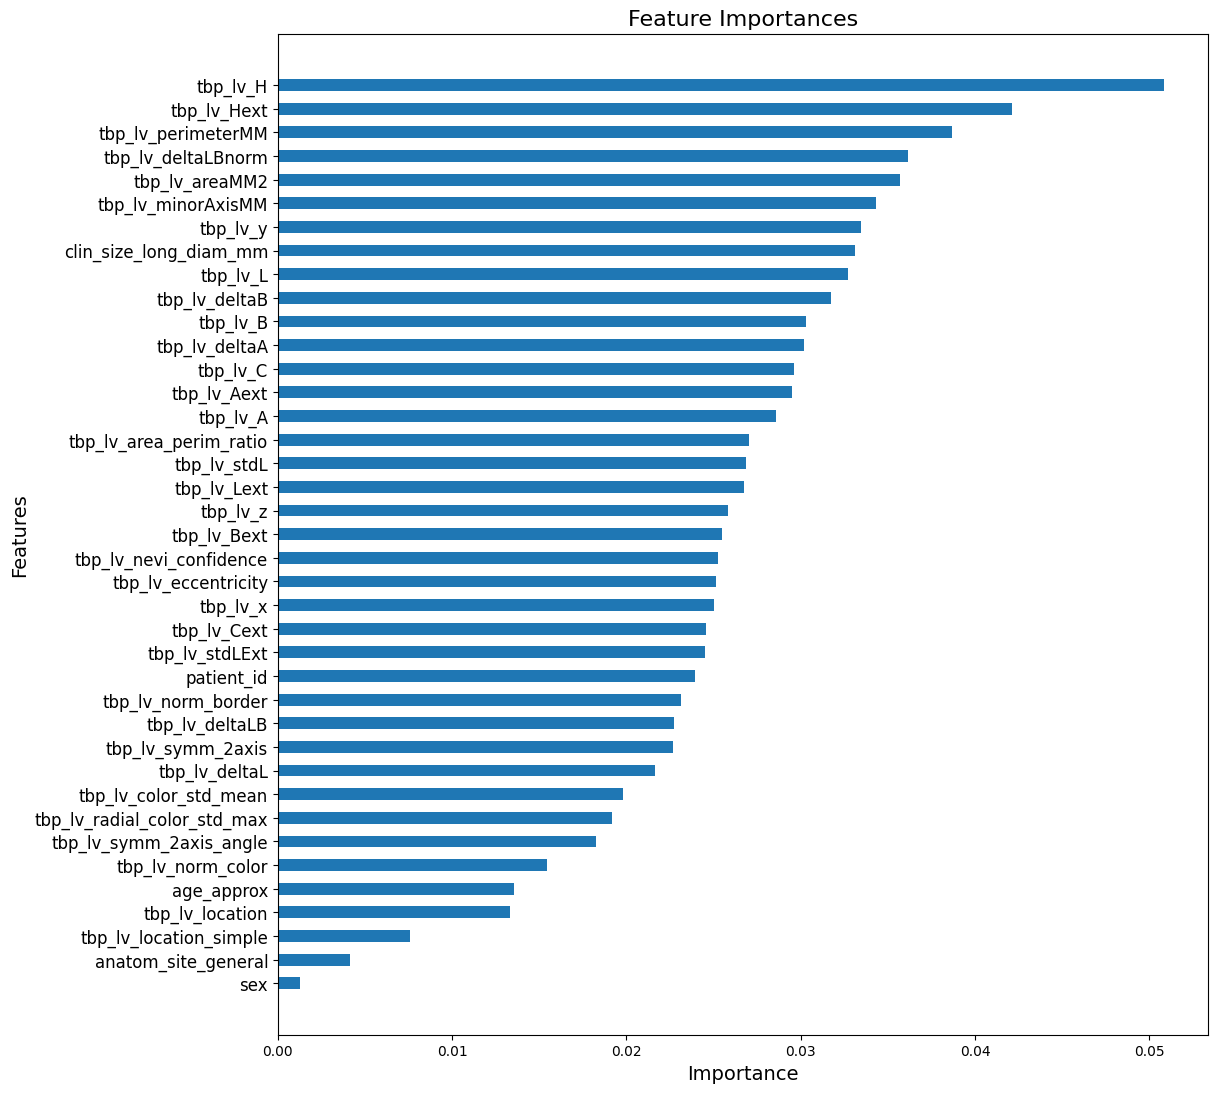

In [16]:
# Importing the plotting library
import matplotlib.pyplot as plt
# Extracting feature importance values from the trained Random Forest model
importance = rf.feature_importances_
# Creating a DataFrame to pair each feature with its importance value and sorting them in ascending order
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': importance}).sort_values('importance', ascending=True)
fig, ax = plt.subplots(figsize=(12, 13))
ax.barh(df_imp['feature'], df_imp['importance'], height=0.5)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.show()


Plotted the feature importances from the Random Forest model to see which features influence the predictions the most. The bars show how important each feature is — higher means more impact. Features like tbp_lv_H, tbp_lv_Hext, and tbp_lv_areaMM2 came out on top, showing they have the most influence on the model.

But many of them are corellated 


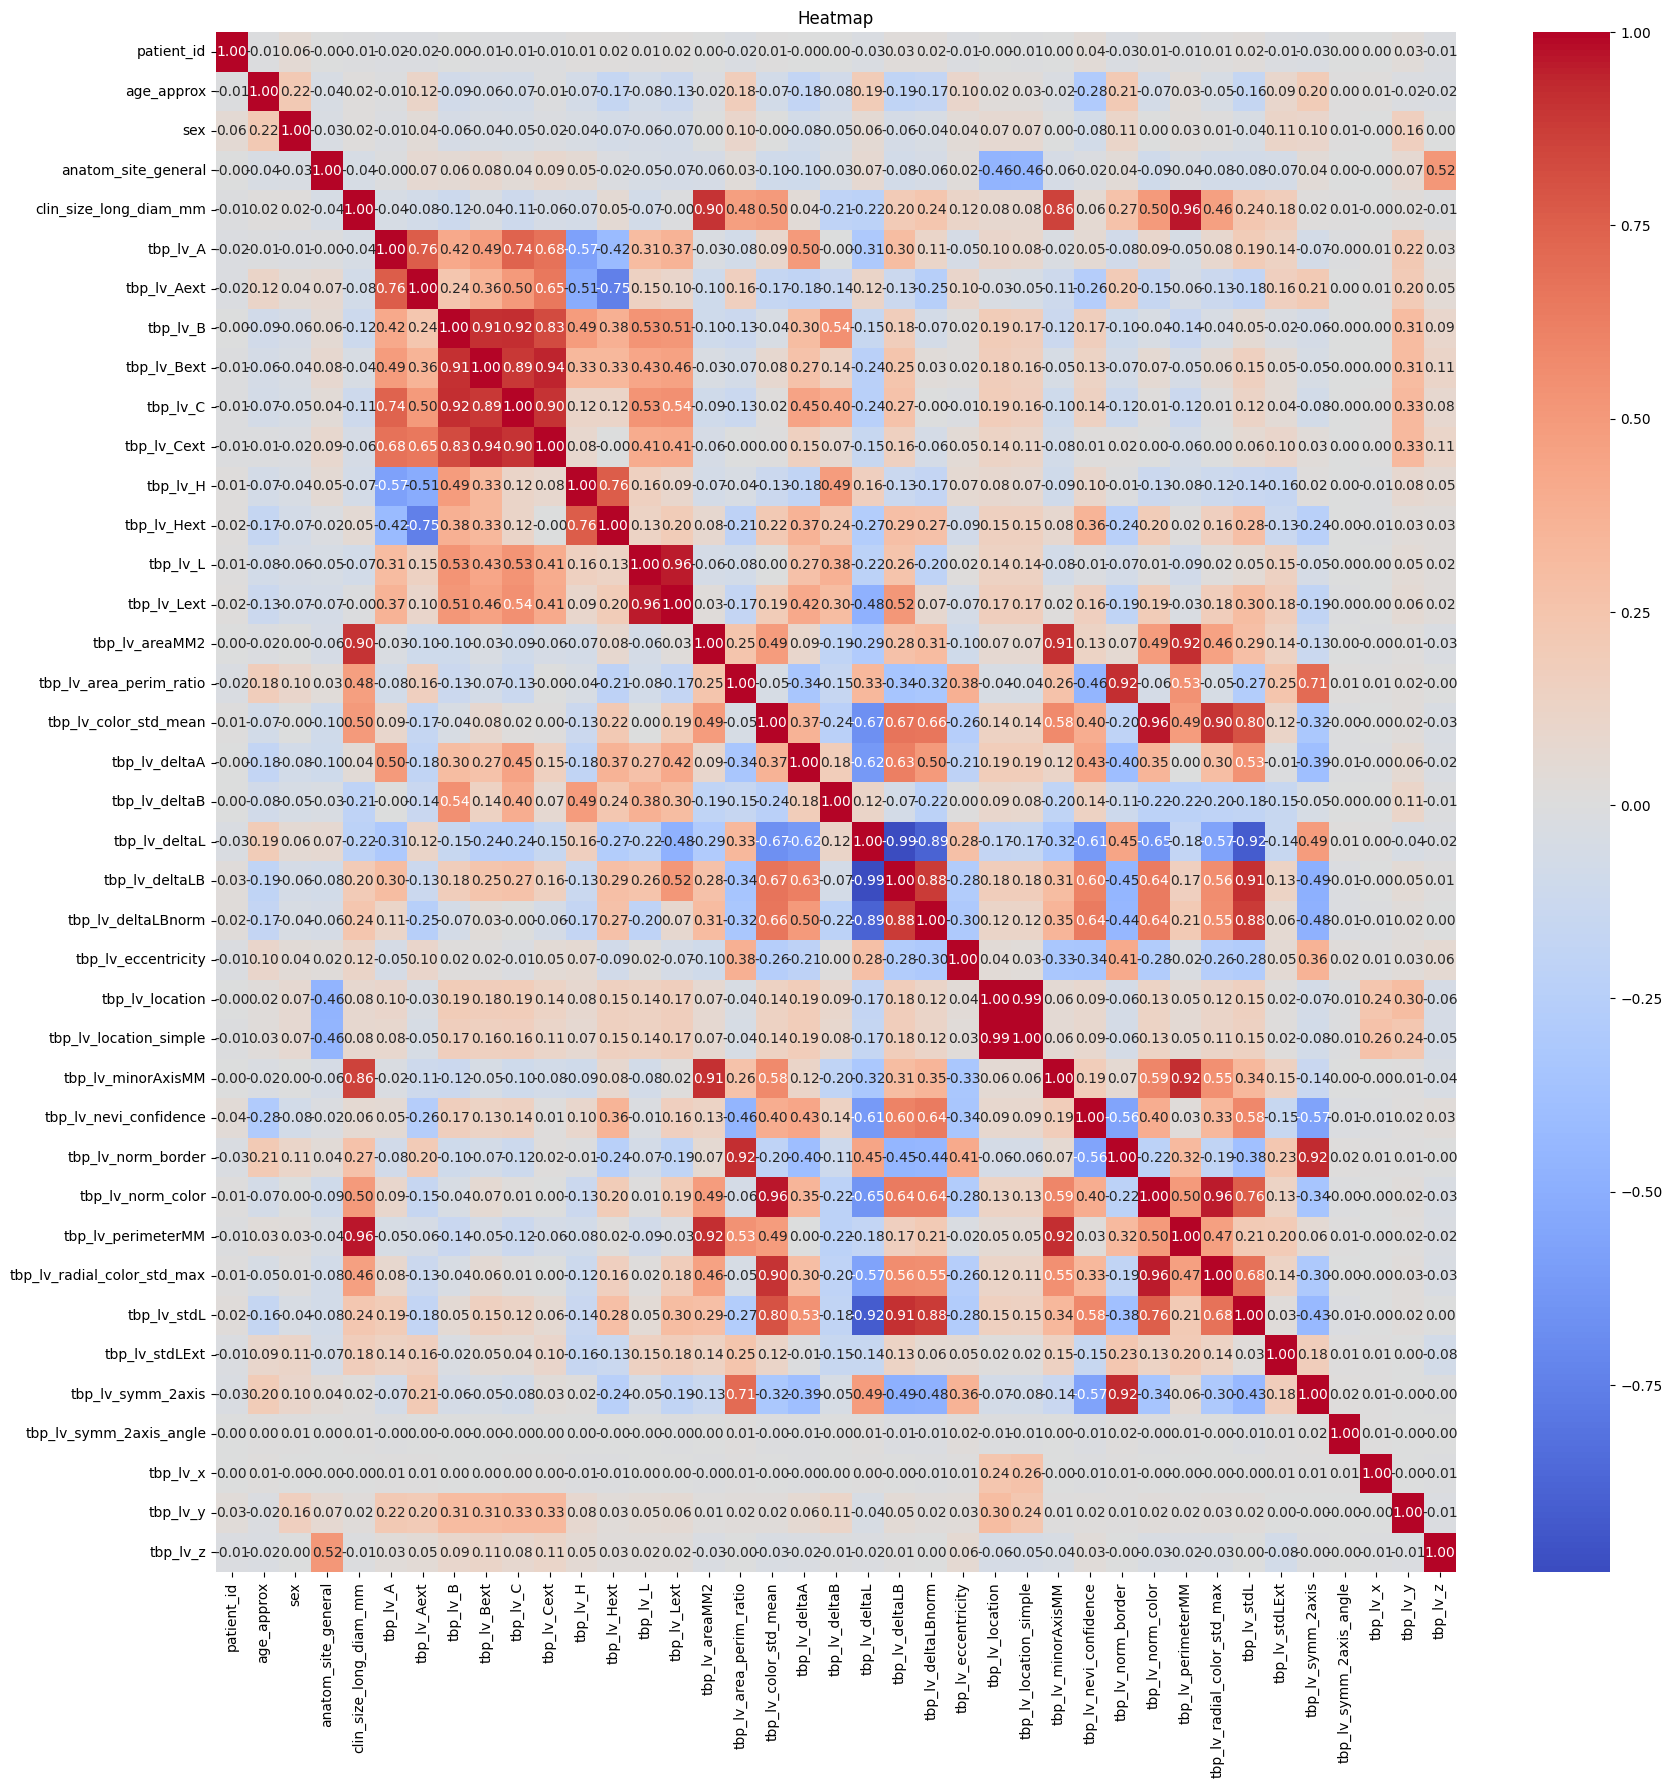

In [18]:
# Importing seaborn for the heatmap
import seaborn as sns 
# Using the training data (assuming it's already scaled/cleaned)
numeric_columns = X_train
# Setting figure size to make the heatmap readable
plt.figure(figsize=(20, 20))
# Calculating the correlation matrix
corr_matrix = numeric_columns.corr()
# Drawing the heatmap 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', annot_kws={'size': 10},cmap='coolwarm')
plt.title('Heatmap')
# Display the heatmap
plt.show()

I created this heatmap to check the correlation between all numeric features. It helps me see which features are closely related — positive values mean strong direct correlation, while negative values mean an inverse relationship. This helps spot multicollinearity and guides feature selection.

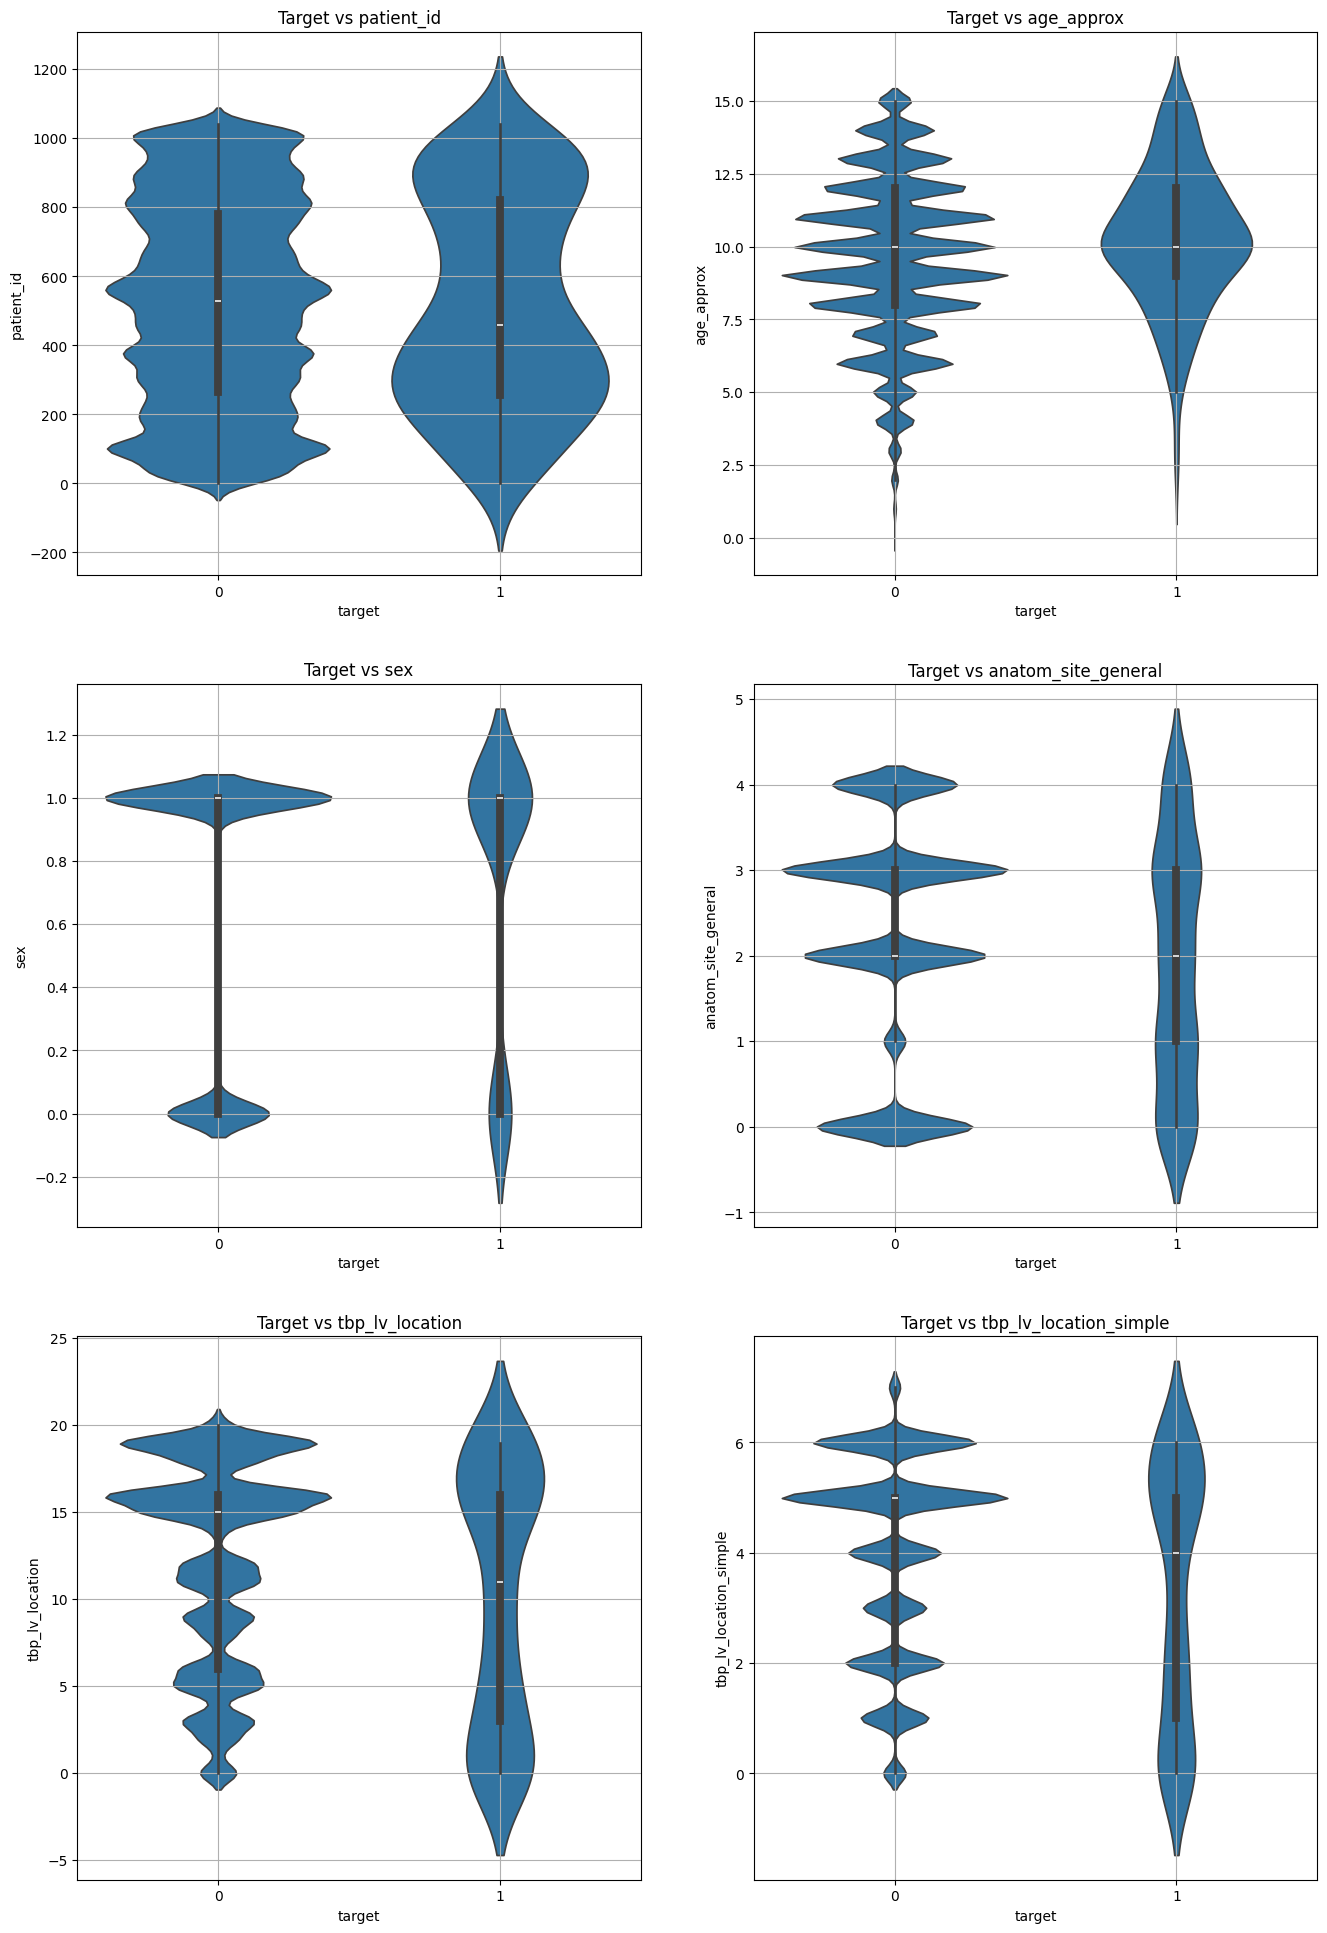

In [19]:
# X_train y_train
df_train = pd.concat([X_train, y_train], axis=1)
# List of categorical or discrete features to visualize
cat_df=['patient_id','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
features=cat_df
# Setting up the layout for subplots (2 plots per row)
fig, axes = plt.subplots(nrows=len(features) // 2 + len(features) % 2, ncols=2, figsize=(16, len(cat_df) * 4))


for i, f in enumerate(features):
    row = i // 2
    col = i % 2
    sns.violinplot(data=df_train, x='target', y=f, ax=axes[row, col])
    axes[row, col].set_title('Target vs ' + f)
    # Add gridlines for better readability
    axes[row, col].grid()

I used violin plots to compare how categorical features like age, sex, and location are distributed across the target classes. This helps me see if certain values are more common in one class than the other, which can guide feature selection or give insights into the data.